In [13]:
# import useful packages
import math
import statistics
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as f
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import time

# set pandas display option
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

# set device
device = torch.device('cuda')

In [14]:
def read_inputs():

    inputs = pd.DataFrame()

    # read input yolo data
    for label_file in Path("data/inputs").iterdir():
        # read labels
        df = pd.read_csv(label_file,sep=" ",names=['id','center-x','center-y','w','h'])

        image_type = str(label_file.name).split('_')

        df['picture'] = [int(image_type[0])] * len(df.index)

        if image_type[1] == "Screen1":
            df['screen'] = [1] * len(df.index)
        elif image_type[1] == "Screen2":
            df['screen'] = [2] * len(df.index)

        inputs = inputs.append(df, ignore_index=True)

    inputs = inputs.sort_values(by=["picture","id", "screen"]).reset_index(drop=True)

    return inputs

inputs = read_inputs()
inputs = inputs[inputs["screen"] == 2]
print(len(inputs.index))
display(inputs)

1846


,id,center-x,center-y,w,h,picture,screen
1,0,0.338281,0.737500,0.145313,0.225000,1,2
3,1,0.589453,0.482639,0.089844,0.129167,1,2
5,2,0.108594,0.520139,0.092188,0.131944,1,2
7,3,0.350000,0.363889,0.059375,0.077778,1,2
9,0,0.327344,0.722917,0.140625,0.215278,2,2
11,1,0.582422,0.475694,0.091406,0.129167,2,2
13,2,0.103906,0.513194,0.095312,0.129167,2,2
15,3,0.357422,0.359028,0.058594,0.084722,2,2
17,0,0.320703,0.706944,0.138281,0.216667,3,2
19,1,0.571875,0.468750,0.085938,0.129167,3,2


In [ ]:
def read_outputs():

    df1 = pd.read_csv("./data/labels/test_gt_coordinates.csv")
    df2 = pd.read_csv("./data/labels/train_gt_coordinates.csv")
    df3 = pd.read_csv("./data/labels/val_gt_coordinates.csv")

    outputs = df1.append(df2, ignore_index=True).append(df3, ignore_index=True).sort_values(by="ID")
    outputs.columns = ["picture", "2.x", "2.z", "3.x", "3.z", "0.x", "0.z", "1.x", "1.z"]

    outputs_0 = outputs.loc[:,['picture','0.x','0.z']]
    outputs_0['id'] = [0] * 500
    outputs_0.columns = ['picture','x', 'z', 'id']

    outputs_1 = outputs.loc[:,['picture','1.x','1.z']]
    outputs_1['id'] = [1] * 500
    outputs_1.columns = ['picture','x', 'z', 'id']

    outputs_2 = outputs.loc[:,['picture','2.x','2.z']]
    outputs_2['id'] = [2] * 500
    outputs_2.columns = ['picture','x', 'z', 'id']

    outputs_3 = outputs.loc[:,['picture','3.x','3.z']]
    outputs_3['id'] = [3] * 500
    outputs_3.columns = ['picture','x', 'z', 'id']

    outputs = outputs_2.append(outputs_3, ignore_index=True).append(outputs_0, ignore_index=True).append(outputs_1, ignore_index=True).sort_values(by = ['picture','id']).reset_index(drop=True)

    return outputs

outputs = read_outputs()
print(len(outputs))
display(outputs)

In [5]:
def filter_outputs():
        for i in range(1,501):
            for j in range(0,4):
                temp = inputs.loc[(inputs['picture'] == i) & (inputs['id'] == j)]
                if temp.empty:
                    outputs.drop(outputs.loc[(outputs['picture'] == i) & (outputs['id'] == j)].index, inplace=True)

filter_outputs()
print(len(outputs))
display(outputs)

In [4]:
'''
Extrinsic Matrices
'''
import numpy as np

# Robot Height
robot_height = 10.9

# Outpost 1 Camera position
o1_point = (-8.98976, 177.5661, 457.6042)

# Outpost 1 Camera to World Matrix
# -0.70486 0.22467    -0.67282   -8.98975
# -0.02764 0.93910    0.34254    177.56610
# -0.70880 -0.26004   0.65573    457.60420
# 0.00000  0.00000    0.00000    1.00000
c2w_matrix_1 = np.array([[-0.70486, 0.22467, -0.67282, -8.98975],
                         [-0.02764, 0.93910, 0.34254, 177.56610],
                         [-0.70880, -0.26004, 0.65573, 457.60420],
                         [0.00000, 0.00000, 0.00000, 1.00000]])

# Outpost 1 Camera Projection Matrix
# 0.87706	0.00000	0.00000	0.00000
# 0.00000	0.49335	0.00000	0.00000
# 0.00000	0.00000	0.00000	-1.00000
# 0.00000	0.00000	-1.66617	1.66717
projection_matrix_1 = np.array([[0.87706,	0.00000, 0.00000, 0.00000],
                                [0.00000,	0.49335, 0.00000, 0.00000],
                                [0.00000,	0.00000, 0.00000, -1.00000],
                                [0.00000,	0.00000, -1.66617, 1.66717]])

# Outpost 3 Camera position
o3_point = (817.1082, 177.5661, -9.41583)

# Outpost 3 Camera to World Matrix
# 0.69863  -0.23571   0.67554    817.10820
# -0.03390 0.93221    0.36032    177.56610
# 0.71468  0.27463    -0.64328   -9.41580
# 0.00000  0.00000    0.00000    1.00000
c2w_matrix_3 = np.array([[0.69863, -0.23571, 0.67554, 817.10820],
                         [-0.03390, 0.93221, 0.36032, 177.56610],
                         [0.71468, 0.27463, -0.64328, -9.41580],
                         [0.00000, 0.00000, 0.00000, 1.00000]])

# Outpost 3 Camera Projection Matrix Inverse
# 0.87706	0.00000	0.00000	0.00000
# 0.00000	0.49335	0.00000	0.00000
# 0.00000	0.00000	0.00000	-1.00000
# 0.00000	0.00000	-1.66617	1.66717
projection_matrix_3 = np.array([[0.87706,	0.00000, 0.00000, 0.00000],
                                [0.00000,	0.49335, 0.00000, 0.00000],
                                [0.00000,	0.00000, 0.00000, -1.00000],
                                [0.00000,	0.00000, -1.66617, 1.66717]])

'''
convert screen point to world point for Outpost 3 - Screen 2

输入的 sp 应该是距离1000的 sp 而不是实际的 sp -> 如何从实际的 sp 求距离1000的 sp?

'''
def s2w(screen_point):
    (sx, sy) = screen_point
    plane_point = np.array([(sx*2-1)*1000, ((1-sy)*2-1)*1000, 1000, 1000])
    matrix = np.dot(c2w_matrix_3, projection_matrix_3)
    world_point = np.dot(matrix, plane_point)
    world_point = world_point[:-1].tolist()
    return world_point

'''
convert world point to robot point for Outpost 3 - Screen 2
'''
def w2r(world_point):
    (x1, y1, z1) = o3_point
    (x2, y2, z2) = world_point
    a1 = y1 - robot_height
    a2 = y1 - y2
    xr = x1 + a1/a2 * (x2-x1)
    zr = z1 + a1/a2 * (z2-z1)
    return xr, zr

1846


,picture,x,z,id
0,1,289.79580,56.15300,0
1,1,189.15910,334.19810,1
2,1,578.79880,99.15597,2
3,1,555.80790,341.15390,3
4,2,279.62180,56.68040,0
5,2,189.69620,344.36450,1
6,2,568.62970,99.68863,2
7,2,545.65060,341.68140,3
8,3,269.52640,57.55946,0
9,3,190.58840,354.44900,1


In [6]:
'''
Process inputs and outpus
data format for inputs are [x,y]
data format for outputs are [x,z]
'''

def process_outputs():
    input_data = []
    output_data = []

    for index, row in inputs.iterrows():
        screen_point = (row['center-x'], row['center-y'])
        world_point = s2w(screen_point)
        robot_point = w2r(world_point)
        print(robot_point)
        test_x, test_z = robot_point
        input_data.append([test_x/808, test_z/448, row['w'], row['h']])

    for index, row in outputs.iterrows():
        output_data.append([row['x']/808, row['z']/448])

    return input_data, output_data

input_data, output_data = process_outputs()
print(len(input_data))
print(len(output_data))

(577.4316779683548, 100.74249342490464)
(545.4462698218144, 352.88895179005385)
(277.8257659403954, 59.55433512618225)
(160.60916123735592, 353.17489316772185)
(566.3162487003599, 100.60316806613217)
(535.0802670844187, 356.7104797869325)
(264.00639702132855, 58.96393828001487)
(154.67592837163318, 367.71974488538797)
(555.6516483489302, 102.44323259706562)
(521.9741268438264, 358.73003304445)
(252.09192074491955, 60.45418070325867)
(159.9381875642498, 374.5273839823211)
(545.1924906166225, 103.49664981654628)
(513.7766248152969, 358.5625467480594)
(239.99684032982577, 62.239665238938315)
(164.92434419632582, 383.9326465678199)
(534.4635949110336, 105.42308135649449)
(502.7887959467164, 360.3899115193648)
(230.51833197746566, 62.903802152780244)
(162.8917099710792, 393.7320288241332)
(524.2654935461298, 107.87490187114648)
(491.77485693626744, 364.0306627339272)
(217.87519013984706, 65.04399573563144)
(165.4907677706832, 404.36243046556365)
(514.5086278347098, 110.72156127364055)
(481.

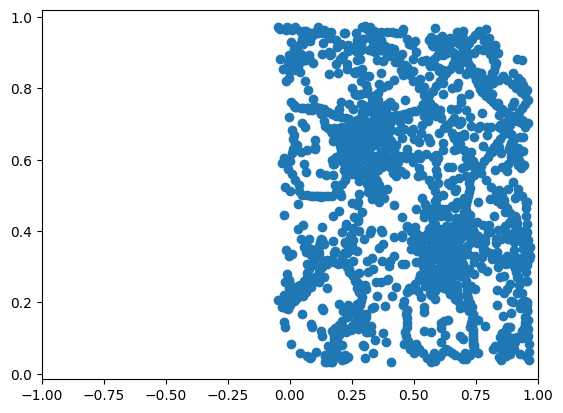

In [7]:
test1 = pd.DataFrame(input_data)
test2 = pd.DataFrame(output_data)

# fig = plt.figure(figsize=(12, 12))
# ax1 = fig.add_subplot(projection='3d')
test1
plt.scatter(test1[0], test2[0])
plt.xlim((-1,1))
plt.show()

In [8]:
'''
Train test split and convert to tensor

[0] data has been removed
'''
input_data_1 = []
output_data_1 = []
for i in range(len(input_data)):
    if input_data[i] != [0]:
        input_data_1.append(input_data[i])
        output_data_1.append(output_data[i])

print(len(input_data_1))
print(len(output_data_1))

# x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2, random_state=42)
input_data = torch.tensor(input_data_1, dtype=torch.float32).to(device)
output_data = torch.tensor(output_data_1, dtype=torch.float32).to(device)

torch.manual_seed(seed=1)

torch_dataset = TensorDataset(input_data, output_data)
train_data, val_test = random_split(torch_dataset,
                                     [1476, 370])
val_data, test_data = random_split(val_test,
                                     [185, 185])

train_data = DataLoader(train_data,
                        batch_size=6,
                        shuffle=True)

1846
1846


In [9]:
'''
define the regression model to regress outcomes
'''
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.input = nn.Linear(4, 10)
        self.h1 = nn.Linear(10,100)
        self.h2 = nn.Linear(100,80)
        self.h3 = nn.Linear(80,50)
        self.output = nn.Linear(50, 2)

    def forward(self, x):
        out = self.input(x)
        out  = torch.relu(out)
        out = self.h1(out)
        out = torch.relu(out)
        out = self.h2(out)
        out = torch.relu(out)
        out = self.h3(out)
        out = torch.relu(out)
        out = self.output(out)
        return out

In [10]:
'''
train the model
'''
lr = 1e-5
epochs = 10000
start_time = time.time()

model = Model()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr)  # 随机梯度下降法
criterion = nn.MSELoss()  # 均方差损失函数

for epoch in range(epochs):
    model.train()
    loses = []

    for _, (train_input, train_output) in enumerate(train_data):

        out = model.forward(train_input) # 计算模型输出结果
        loss = criterion(out, train_output)  # 损失函数
        loses.append(loss.item())
        optimizer.zero_grad()  # 梯度清零
        loss.backward()  # 计算梯度 后向传递过程
        optimizer.step() # 优化权重与偏差矩阵

    logit = []  # 这个是验证集，可以根据验证集的结果进行调参，这里根据验证集的结果选取最优的神经网络层数与神经元数目
    target = []
    model.eval() # 启动测试模式
    for data, targets in val_data:  # 输出验证集的平均误差
        logits = model.forward(data).detach().cpu().numpy()
        targets=targets.detach().cpu().numpy()
        logit.append(logits[0])
        target.append(targets[0])
    average_loss =  criterion(torch.tensor(logit), torch.tensor(target))

    if epoch%100 == 0:
      print(epoch, average_loss, sum(loses)/len(loses), sep='\t')

end_time = time.time()
print("Time usage is", (end_time - start_time))

0	tensor(0.4159)	0.35183021771471673
100	tensor(0.0712)	0.06655827544750721
200	tensor(0.0713)	0.06569068797114419
300	tensor(0.0709)	0.06506758153711151


KeyboardInterrupt: 